In [1]:
import keras
from keras import layers
from keras import ops

import matplotlib.pyplot as plt

2025-10-20 15:37:38.431796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [3]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 5   #CHANGE THIS TO HANDLE MEMORY SHORTAGE
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

I0000 00:00:1760967469.198964   11978 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8945 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [5]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        B, C = ops.shape(x)[0], ops.shape(x)[-1]
        x = ops.image.extract_patches(x, self.patch_size)
        x = ops.reshape(x, (B, -1, self.patch_size * self.patch_size * C))
        return x


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch, step=1)
        return self.proj(patch) + self.pos_embed(pos)

In [6]:
def external_attention(
    x,
    dim,
    num_heads,
    dim_coefficient=4,
    attention_dropout=0,
    projection_dropout=0,
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = ops.reshape(x, (-1, num_patch, num_heads, dim * dim_coefficient // num_heads))
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = layers.Lambda(
        lambda attn: ops.divide(
            attn,
            ops.convert_to_tensor(1e-9) + ops.sum(attn, axis=-1, keepdims=True),
        )
    )(attn)
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    x = ops.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [7]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=ops.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [8]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=attention_dropout,
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [9]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/50


2025-10-20 15:38:01.330731: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 210s 25ms/step - accuracy: 0.0577 - loss: 4.3366 - top-5-accuracy: 0.1970 - val_accuracy: 0.0903 - val_loss: 4.8187 - val_top-5-accuracy: 0.2764
Epoch 2/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 208s 26ms/step - accuracy: 0.1473 - loss: 3.7957 - top-5-accuracy: 0.3937 - val_accuracy: 0.0875 - val_loss: 5.6785 - val_top-5-accuracy: 0.2604
Epoch 3/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 214s 27ms/step - accuracy: 0.1869 - loss: 3.6172 - top-5-accuracy: 0.4526 - val_accuracy: 0.0990 - val_loss: 6.1700 - val_top-5-accuracy: 0.2735
Epoch 4/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 219s 27ms/step - accuracy: 0.2137 - loss: 3.5125 - top-5-accuracy: 0.4908 - val_accuracy: 0.1131 - val_loss: 5.5518 - val_top-5-accuracy: 0.3000
Epoch 5/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 217s 27ms/step - accuracy: 0.2311 - loss: 3.4276 - top-5-accuracy: 0.5186 - val_accuracy: 0.0954 - val_loss: 6.7484 - val_top-5-accuracy: 0.2807
Epoch 6/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 219s 27ms/step - accuracy: 0.2463 

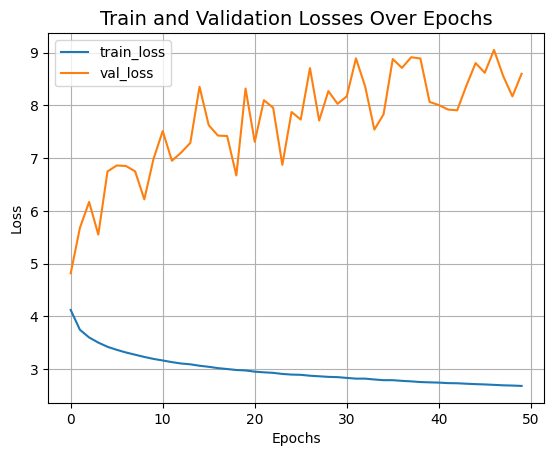

In [11]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [12]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1006 - loss: 8.5454 - top-5-accuracy: 0.2718
Test loss: 8.55
Test accuracy: 9.81%
Test top 5 accuracy: 26.9%
